## Setup: Read in All the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

file_paths = [
    "data/prices_round_1_day_-2.csv", 
    "data/prices_round_1_day_-1.csv", 
    "data/prices_round_1_day_0.csv"
]

combined_df = pd.concat([pd.read_csv(file, delimiter=';') for file in file_paths], ignore_index=True)

combined_df['full_time'] = combined_df['day'].astype(str) + "_" + combined_df['timestamp'].astype(str)
# Convert mid_price to a string, clean it (remove extra whitespace, and replace commas with periods if needed),
# then convert to numeric and drop rows that cannot be converted.
combined_df['mid_price'] = combined_df['mid_price'].astype(str).str.strip()
combined_df['mid_price'] = combined_df['mid_price'].str.replace(',', '.', regex=False)
combined_df['mid_price'] = pd.to_numeric(combined_df['mid_price'], errors='coerce')
combined_df.dropna(subset=['mid_price'], inplace=True)
combined_df = combined_df.sort_values(by=['day', 'timestamp'])


squid_ink_df = combined_df[combined_df['product'] == 'SQUID_INK'].reset_index(drop=True)
rainforest_resin_df = combined_df[combined_df['product'] == 'RAINFOREST_RESIN'].reset_index(drop=True)
kelp_df = combined_df[combined_df['product'] == 'KELP'].reset_index(drop=True)

## Simple Graphs to Show Price Over Time

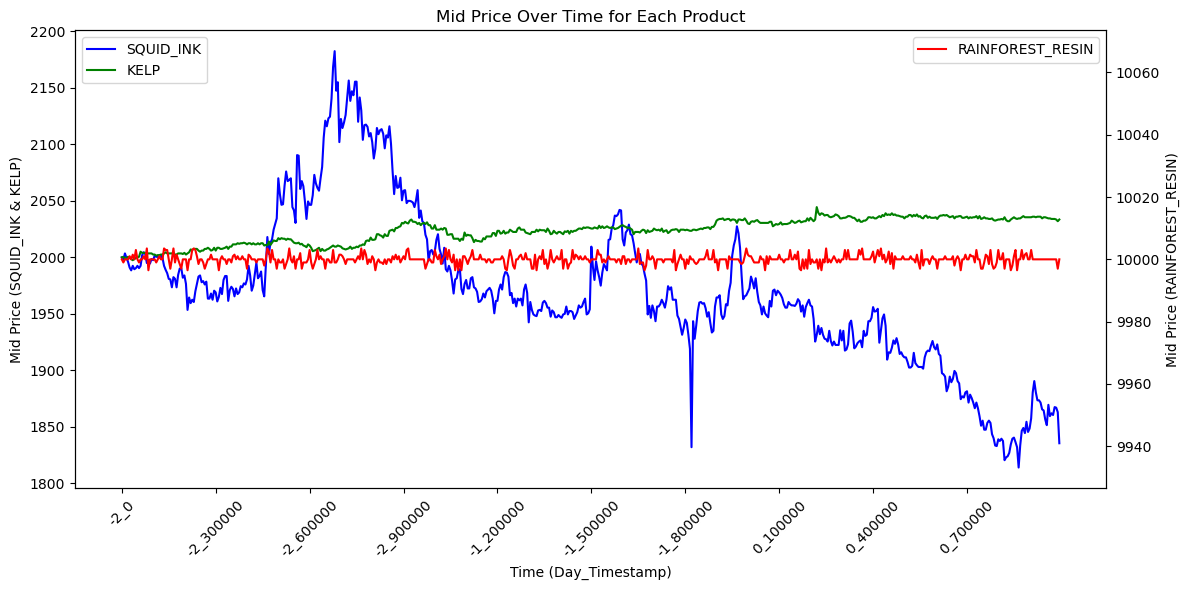

In [2]:
# downsample by taking every 50th point
squid_ink_df_downsized = combined_df[combined_df['product'] == 'SQUID_INK'].iloc[::50].reset_index(drop=True)
rainforest_resin_df_downsized = combined_df[combined_df['product'] == 'RAINFOREST_RESIN'].iloc[::50].reset_index(drop=True)
kelp_df_downsized = combined_df[combined_df['product'] == 'KELP'].iloc[::50].reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(squid_ink_df_downsized['full_time'], squid_ink_df_downsized['mid_price'], label='SQUID_INK', color='blue')
ax1.plot(kelp_df_downsized['full_time'], kelp_df_downsized['mid_price'], label='KELP', color='green')

ax1.set_xlabel('Time (Day_Timestamp)')
ax1.set_ylabel('Mid Price (SQUID_INK & KELP)')
ax1.set_title('Mid Price Over Time for Each Product')
ax1.legend(loc='upper left')

x_ticks = squid_ink_df_downsized['full_time'][::max(1, len(squid_ink_df_downsized) // 10)]
ax1.set_xticks(x_ticks)
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(rainforest_resin_df_downsized['full_time'], rainforest_resin_df_downsized['mid_price'], label='RAINFOREST_RESIN', color='red')

rain_min = rainforest_resin_df_downsized['mid_price'].min()
rain_max = rainforest_resin_df_downsized['mid_price'].max()
padding = (rain_max - rain_min) * 10 
ax2.set_ylim(rain_min - padding, rain_max + padding)
ax2.set_ylabel('Mid Price (RAINFOREST_RESIN)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Notes from Round 1 Online 
The value of the **Rainforest Resin has been stable** throughout the history of the archipelago, the value of **Kelp has been going up and down over time**, and the value of **Squid Ink can also swing a bit**, but some say there is a pattern to be discovered in its prize progression.

## Finding a Strategy for Rainforest Resin

<Axes: title={'center': 'Z-Score of RAINFOREST_RESIN Mid Price'}>

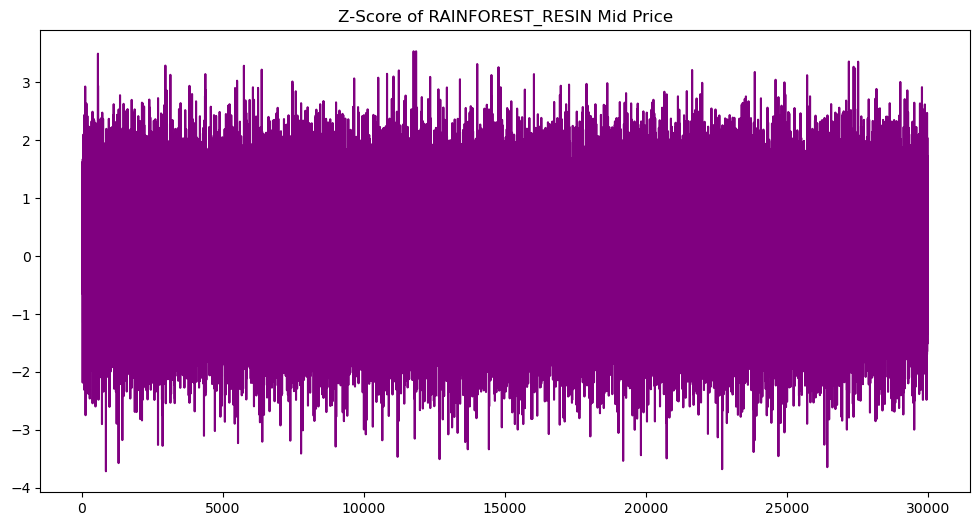

In [3]:
# Define a rolling window size. Adjust based on your preference, e.g., 20 or 50
window_size = 20

# Calculate the rolling mean and rolling standard deviation of 'mid_price'
rainforest_resin_df['rolling_mean'] = rainforest_resin_df['mid_price'].rolling(window=window_size).mean()
rainforest_resin_df['rolling_std'] = rainforest_resin_df['mid_price'].rolling(window=window_size).std()

# Calculate the Z-Score
rainforest_resin_df['z_score'] = (rainforest_resin_df['mid_price'] - rainforest_resin_df['rolling_mean']) / rainforest_resin_df['rolling_std']

# Drop rows where rolling statistics are NaN (before enough data is collected)
rainforest_resin_df.dropna(subset=['rolling_mean', 'rolling_std'], inplace=True)

rainforest_resin_df['z_score'].plot(figsize=(12, 6), title='Z-Score of RAINFOREST_RESIN Mid Price', color='purple')



The basic strategy here is to use the z-score and buy/sell when it is below/above a certain threshold.

## Finding the Pattern in Squid Ink
"the value of **Squid Ink can also swing a bit**, but some say **there is a pattern** to be discovered in its prize progression"

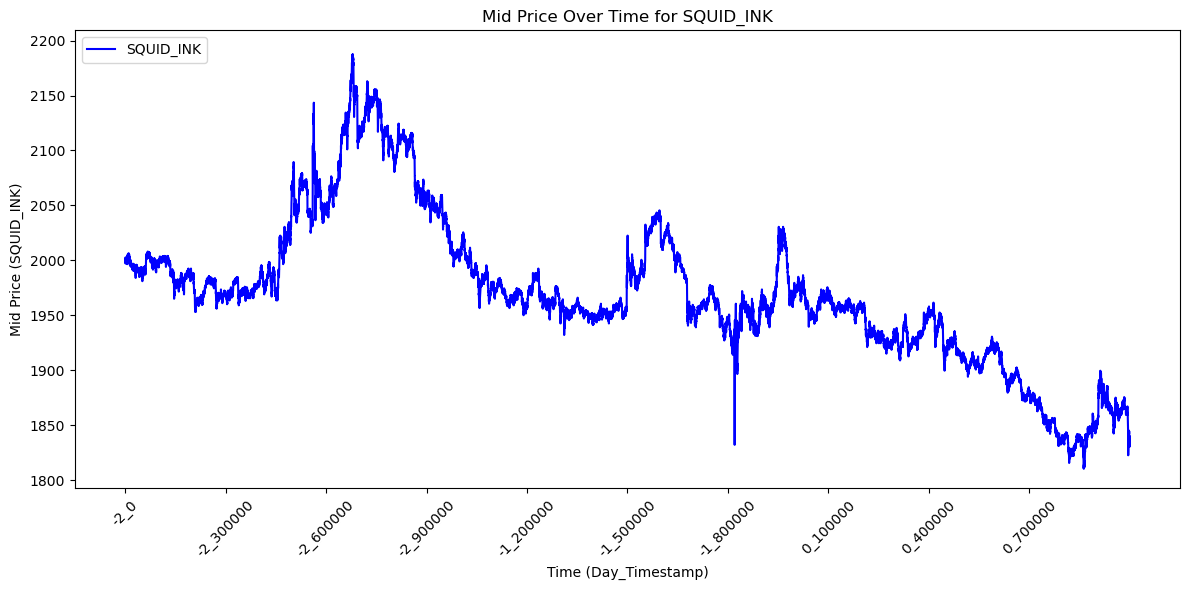

In [4]:
# first, plot only the squid ink so we can better visualize it
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(squid_ink_df['full_time'], squid_ink_df['mid_price'], label='SQUID_INK', color='blue')
ax.set_xlabel('Time (Day_Timestamp)')
ax.set_ylabel('Mid Price (SQUID_INK)')
ax.set_title('Mid Price Over Time for SQUID_INK')
ax.legend(loc='upper left')
x_ticks = squid_ink_df['full_time'][::max(1, len(squid_ink_df) // 10)]
ax.set_xticks(x_ticks)
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(squid_ink_df['mid_price'].min() * 0.99, squid_ink_df['mid_price'].max() * 1.01)  # Adjust y-axis limit for better visibility
plt.tight_layout()
plt.show()

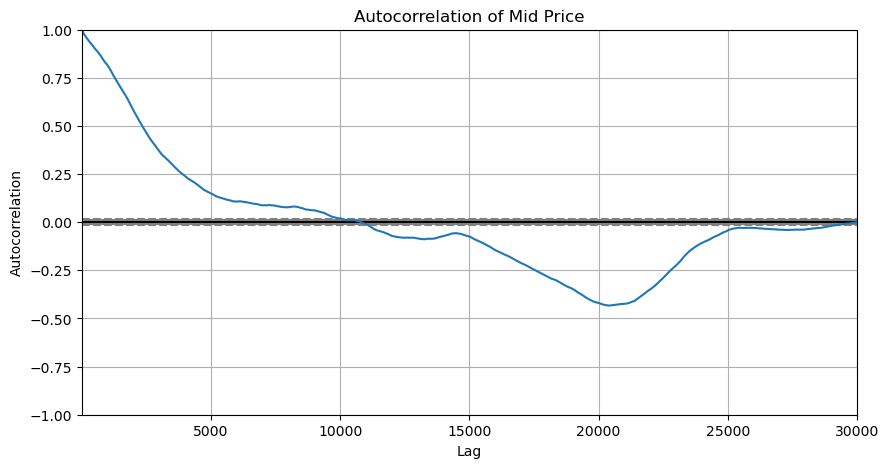

In [5]:
# perform autocorrection to see if there is correlation of price with past values
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,5))
autocorrelation_plot(squid_ink_df['mid_price'])
plt.title('Autocorrelation of Mid Price')
plt.show()


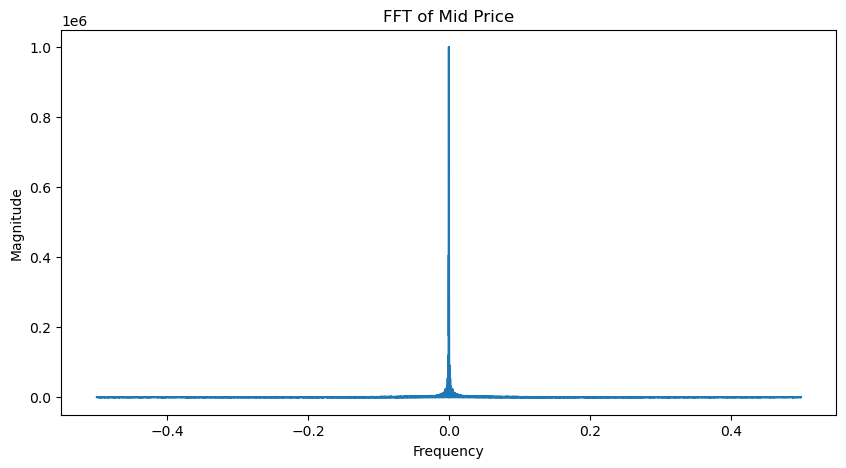

In [6]:
# foureir analysis to see fi there are dominant frequencies
import numpy as np

fft_vals = np.fft.fft(squid_ink_df['mid_price'] - squid_ink_df['mid_price'].mean())
fft_freq = np.fft.fftfreq(len(fft_vals))
plt.figure(figsize=(10,5))
plt.plot(fft_freq, np.abs(fft_vals))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT of Mid Price')
plt.show()

### Try to Do a Augoregressive Model

Total SQUID_INK rows for modeling: 30000
Rows after adding lag features: 29988
Model Coefficients:
Intercept: 0.39903304835706876
Lag Coefficients: [ 0.81988331  0.1248814   0.07095404 -0.01592438]


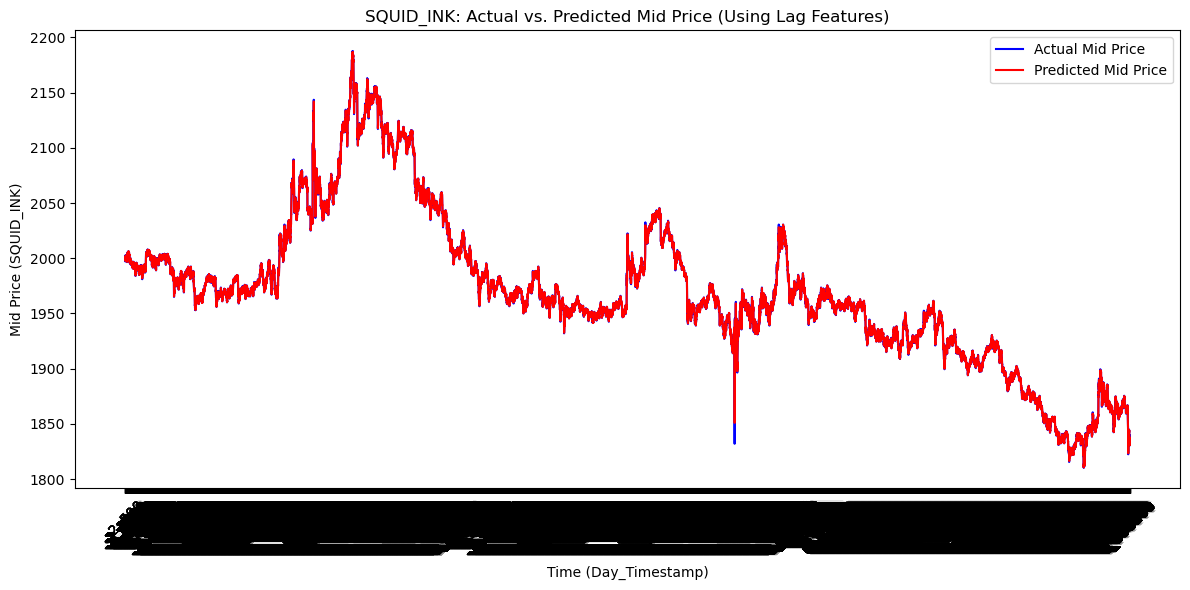

In [8]:
from sklearn.linear_model import LinearRegression

# Use the full SQUID_INK dataset (make sure this came AFTER converting mid_price to numeric)
squid_ink_full_df = combined_df[combined_df['product'] == 'SQUID_INK'].reset_index(drop=True)
print("Total SQUID_INK rows for modeling:", squid_ink_full_df.shape[0])

# Build a lagged DataFrame from the full dataset
lag = 4
squid_lag_df = squid_ink_full_df.copy()

# Apply shift within each day group
for i in range(1, lag + 1):
    squid_lag_df[f'lag_{i}'] = squid_lag_df.groupby('day')['mid_price'].shift(i)

# Drop rows that have NaN in any of the lag columns (only the first few rows in each day)
squid_lag_df.dropna(subset=[f'lag_{i}' for i in range(1, lag + 1)], inplace=True)
squid_lag_df.reset_index(drop=True, inplace=True)

print("Rows after adding lag features:", squid_lag_df.shape[0])

# Prepare features and target for the model
features = [f'lag_{i}' for i in range(1, lag + 1)]
X = squid_lag_df[features].values
y = squid_lag_df['mid_price'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

print("Model Coefficients:")
print("Intercept:", model.intercept_)
print("Lag Coefficients:", model.coef_)

# Predict the mid_price using the model
squid_lag_df['predicted_mid_price'] = model.predict(X)

# Plot actual vs. predicted mid_price over time
plt.figure(figsize=(12, 6))
plt.plot(squid_lag_df['full_time'], squid_lag_df['mid_price'], label='Actual Mid Price', color='blue')
plt.plot(squid_lag_df['full_time'], squid_lag_df['predicted_mid_price'], label='Predicted Mid Price', color='red')
plt.xlabel('Time (Day_Timestamp)')
plt.ylabel('Mid Price (SQUID_INK)')
plt.title('SQUID_INK: Actual vs. Predicted Mid Price (Using Lag Features)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Determine the split index (80% of the data)
split_index = int(0.8 * len(squid_lag_df))

# Create training and testing datasets based on the split index
train_df = squid_lag_df.iloc[:split_index]
test_df = squid_lag_df.iloc[split_index:]

# Define features (lag columns)
features = [f'lag_{i}' for i in range(1, 5)]  # Change 5 to your lag+1 if needed

# Prepare X (features) and y (target) for training and testing
X_train = train_df[features].values
y_train = train_df['mid_price'].values

X_test = test_df[features].values
y_test = test_df['mid_price'].values

from sklearn.linear_model import LinearRegression

# Initialize and train the model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Predict mid_price for the test set
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test R^2:", r2)